In [16]:
import json
import numpy as np # linear algebra
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#sarcasm_setection_df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json')
#with open("/content/drive/My Drive/Projects/Sarcasm Detection/Sarcasm_Headlines_Dataset_v2.json", 'r') as sarcasm_json:
  #sarcasm_setection_df = json.load(sarcasm_json)

sarcasm_setection_df = pd.read_json(r'/content/drive/My Drive/Projects/Sarcasm Detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [9]:
sarcasm_setection_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [12]:
sarcasm_setection_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_sarcastic,28619,NaN,NaN,NaN,0.476397,0.499451,0,0,0,1,1
headline,28619,28503,"'no way to prevent this,' says only nation whe...",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_link,28619,28617,https://www.huffingtonpost.comhttp://nymag.com...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
sarcasm_setection_df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

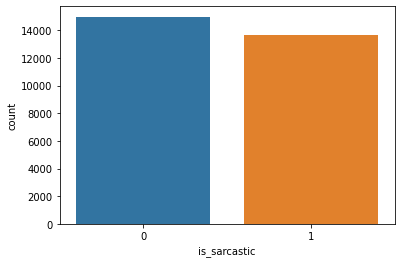

In [17]:
sns.countplot(sarcasm_setection_df.is_sarcastic)

### We can see that Dataset is balanced

In [18]:
sarcasm_setection_df.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [22]:
nltk.download('stopwords')
sarcasm_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Removing the square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)
  #Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in sarcasm_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
sarcasm_setection_df['headline'] = sarcasm_setection_df['headline'].apply(denoise_text)

WordCloud For Not Sarcastic (LABEL - 0)

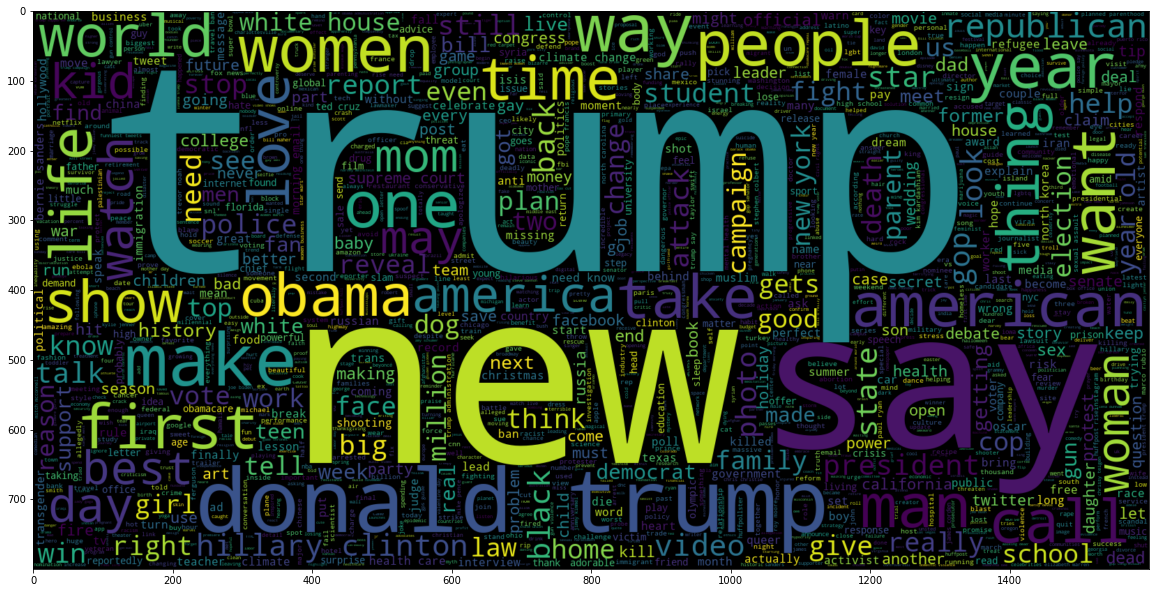

In [27]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm_setection_df[sarcasm_setection_df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

WordCloud For Sarcastic (LABEL - 1)

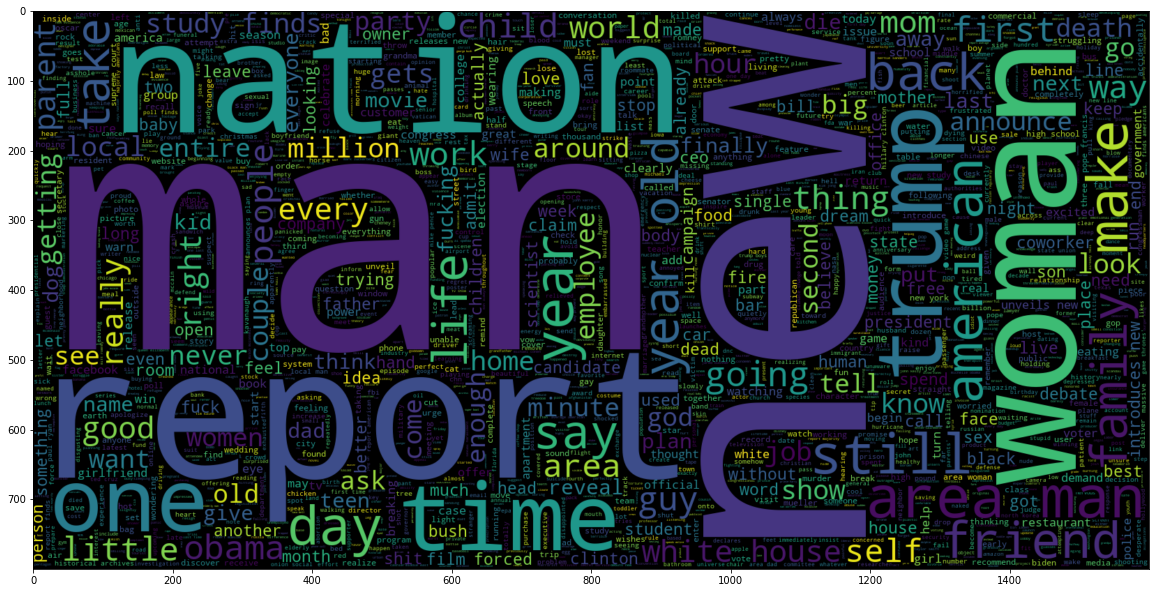

In [28]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm_setection_df[sarcasm_setection_df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

### Why do we need Word Embeddings?
Consider the following similar sentences: Have a good day and Have a great day. They hardly have different meaning. If we construct an exhaustive vocabulary (let’s call it V), it would have V = {Have, a, good, great, day}. Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better. Have = [1,0,0,0,0] ; a=[1,0,0,0,0] ; good=[0,0,1,0,0] ; great=[0,0,0,1,0] ; day=[0,0,0,0,1] (represents transpose) If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true. Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.

https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

In [0]:
sentences = []
for i in sarcasm_setection_df.headline.values:
   sentences.append(i.split())

In [34]:
sentences[:2]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality']]

In [41]:
len(sarcasm_setection_df.headline)

28619

In [0]:
tokenizer = text.Tokenizer(num_words=35000,oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
tokenized_train = tokenizer.texts_to_sequences(sentences)
headlines_x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [44]:
label_word_index = tokenizer.word_index
print(label_word_index)

{'<OOV>': 1, 'new': 2, 'man': 3, 'trump': 4, 'one': 5, 'area': 6, 'woman': 7, 'says': 8, 'donald': 9, 'report:': 10, 'u.s.': 11, 'day': 12, 'like': 13, 'get': 14, 'first': 15, 'time': 16, "trump's": 17, 'people': 18, 'still': 19, 'house': 20, 'white': 21, 'make': 22, 'life': 23, 'obama': 24, 'back': 25, 'women': 26, 'could': 27, 'clinton': 28, 'americans': 29, 'way': 30, 'world': 31, 'family': 32, 'would': 33, 'gop': 34, 'finds': 35, 'bill': 36, 'really': 37, 'black': 38, 'years': 39, '5': 40, "can't": 41, 'school': 42, 'police': 43, 'best': 44, 'nation': 45, 'know': 46, 'going': 47, 'every': 48, 'american': 49, 'last': 50, 'death': 51, "'the": 52, 'say': 53, 'state': 54, 'campaign': 55, 'home': 56, 'getting': 57, 'health': 58, 'things': 59, 'president': 60, 'mom': 61, 'good': 62, 'may': 63, 'show': 64, 'big': 65, 'gets': 66, 'hillary': 67, 'year': 68, 'need': 69, 'little': 70, 'take': 71, 'video': 72, 'work': 73, 'parents': 74, 'study': 75, 'makes': 76, 'love': 77, 'john': 78, 'never'

In [0]:
vocab_size = len(tokenizer.word_index)
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, input_length=20))
#LSTM 
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           3807500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,924,877
Trainable params: 3,924,877
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_train, x_test, y_train, y_test = train_test_split(headlines_x, sarcasm_setection_df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [55]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/5
20033/20033 [==============================] - 26s 1ms/step - loss: 0.5384 - acc: 0.7116 - val_loss: 0.4221 - val_acc: 0.8015
Epoch 2/5
20033/20033 [==============================] - 25s 1ms/step - loss: 0.2513 - acc: 0.9002 - val_loss: 0.4485 - val_acc: 0.8083
Epoch 3/5
20033/20033 [==============================] - 25s 1ms/step - loss: 0.1090 - acc: 0.9617 - val_loss: 0.5323 - val_acc: 0.8005
Epoch 4/5
20033/20033 [==============================] - 23s 1ms/step - loss: 0.0493 - acc: 0.9845 - val_loss: 0.7111 - val_acc: 0.8004
Epoch 5/5
20033/20033 [==============================] - 24s 1ms/step - loss: 0.0288 - acc: 0.9918 - val_loss: 0.8923 - val_acc: 0.7921


In [0]:
pred = model.predict_classes(x_test)

In [0]:
confusion_matrix = confusion_matrix(y_test,pred)

In [62]:
confusion_matrix

array([[3606,  954],
       [ 801, 3225]])

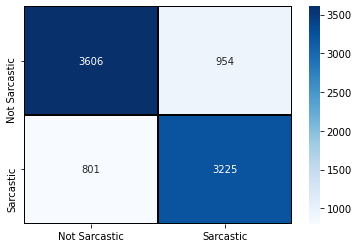

In [63]:
sns.heatmap(confusion_matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

### Model is overfit as it is trained on default Keras embeddings, Next we can try to train using pre trained word embeddings.